# Cloud Optimized Geotiff

In short, a cloud-optimized GeoTIFF (COG) is a geospatial data file format designed for efficient storage, access, and processing in cloud computing environments. It divides the image data into smaller tiles, includes multiple versions of the image at different resolutions, optimizes metadata organization, and supports incremental data retrieval. COGs enable faster data access and processing in the cloud, making them ideal for large-scale geospatial analysis and visualization.

> "As a cartographer of old, I have witnessed the winds of change carry our maps from parchment to pixels. The Cloud-Optimized GeoTIFF, a marvel of modern ingenuity, transcends the boundaries of time and space. It breathes life into geospatial data, transforming it into a nimble and scalable form that dances effortlessly across the celestial canvas. Like a masterful cartographic symphony, COG orchestrates the harmony between efficient storage, seamless access, and celestial processing, empowering explorers to chart uncharted territories with grace and precision."
>
> ChatGPT

- [Open Geospatial Consortium COG spec](https://github.com/opengeospatial/CloudOptimizedGeoTIFF)

To work with cogs, we will use `rio-cogeo`, `rio-tiler` and `cog-worker`

In [45]:
import numpy as np
import rasterio as rio
from rio_tiler.io import Reader
import matplotlib.pyplot as plt
import folium

import utils

In [3]:
!rio cogeo info ../data/sentinel_cog.tif

Driver: GTiff
File: /home/bielstela/vizzuality/dev/jornades-sig-lliure/data/sentinel_cog.tif
COG: True
Compression: DEFLATE
ColorSpace: None

Profile
    Width:            10980
    Height:           10980
    Bands:            3
    Tiled:            True
    Dtype:            uint8
    NoData:           0.0
    Alpha Band:       False
    Internal Mask:    False
    Interleave:       PIXEL
    ColorMap:         False
    ColorInterp:      ('red', 'green', 'blue')
    Scales:           (1.0, 1.0, 1.0)
    Offsets:          (0.0, 0.0, 0.0)

Geo
    Crs:              EPSG:32636
    Origin:           (499980.0, 1900020.0)
    Resolution:       (10.0, -10.0)
    BoundingBox:      (499980.0, 1790220.0, 609780.0, 1900020.0)
    MinZoom:          8
    MaxZoom:          14

Image Metadata
    AREA_OR_POINT: Area
    OVR_RESAMPLING_ALG: AVERAGE

Image Structure
    COMPRESSION: DEFLATE
    INTERLEAVE: PIXEL
    PREDICTOR: 2

Band 1
    ColorInterp: red

Band 2
    ColorInterp: green

Band 3
 

### Full raster

In [9]:
%%time
with rio.open("../data/sentinel_cog.tif") as src:
    data = src.read()

CPU times: user 2.12 s, sys: 170 ms, total: 2.29 s
Wall time: 2.28 s


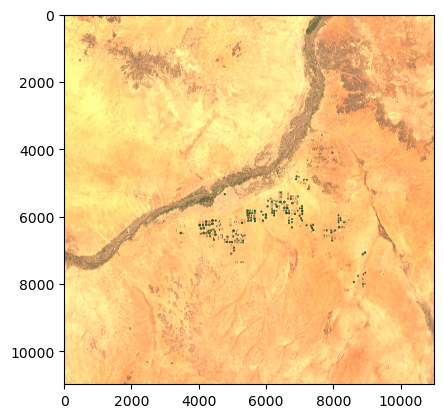

In [13]:
ax = rio.plot.show(data)

## Overviews

In [31]:
decimations = [2**x for x in range(5)]
decimations

[1, 2, 4, 8, 16]

(3, 10980, 10980)


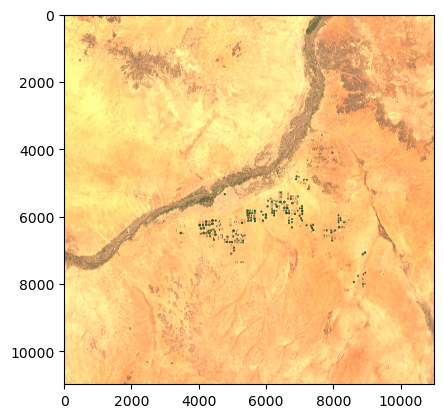

(3, 5490, 5490)


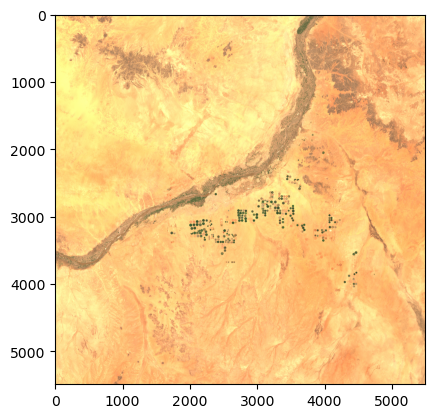

(3, 2745, 2745)


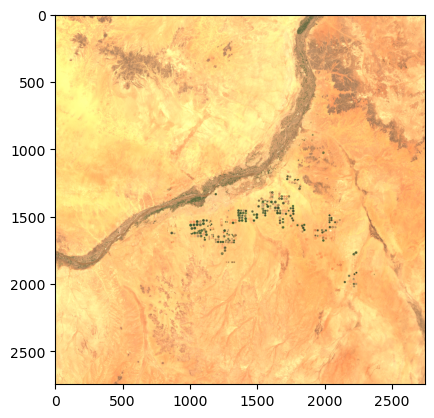

(3, 1372, 1372)


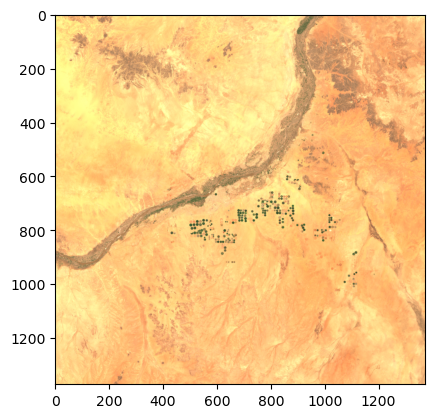

/tmp/ipykernel_31156/3139476479.py:9: RuntimeWarning: invalid value encountered in cast
  arr = np.empty(shape=out_shape).astype(src.profile['dtype'])


(3, 686, 686)


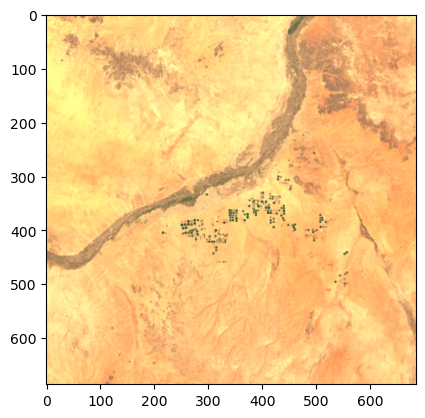

In [51]:
overviews = []
with rio.open("../data/sentinel_cog.tif") as src:
    bounds_4326 = rio.warp.transform_bounds(src.crs, "epsg:4316", *src.bounds)
    for overview_level in decimations:
        # Reading into a given shape, makes rasterio 
        # to read from the overviews. Controling the shape
        # we can control wich overview are we reading from
        out_shape = (3, src.shape[0]//overview_level , src.shape[1]//overview_level)
        arr = np.empty(shape=out_shape).astype(src.profile['dtype'])
        arr = src.read(out=arr)
        overviews.append(arr)
        print(out_shape)
        rio.plot.show(arr)


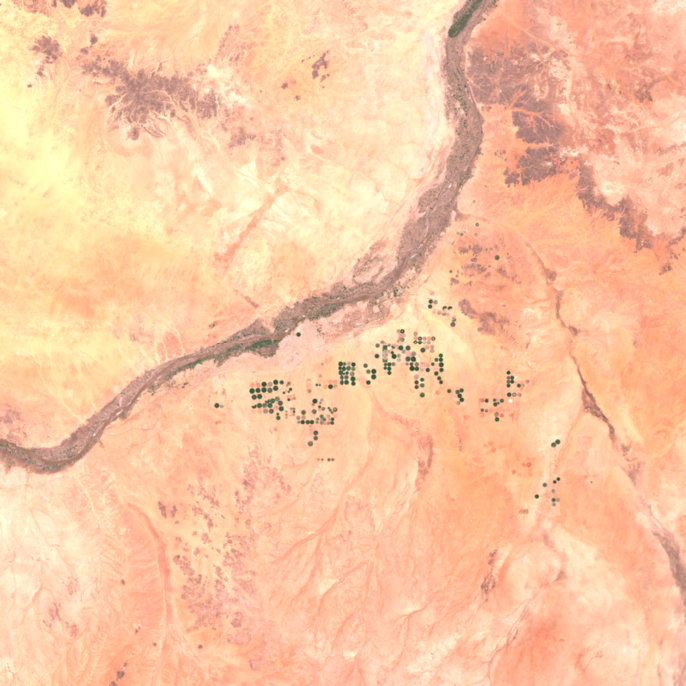

In [55]:
m = folium.Map([16.6, 33.4], zoom_start=11)
folium.raster_layers. ImageOverlay(
    image=rio.plot.reshape_as_image(overviews[-1]),
    bounds=utils.convert_bounds(bounds_4326),
).add_to(m)

folium.LayerControl().add_to(m)
m